# 1. 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import re
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
import matplotlib as mpl
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import gc
import statistics as st
plt.rcParams['font.family'] = 'Malgun Gothic'
rc={'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 12.0, 'axes.titlesize': 20}
plt.rcParams.update(**rc)
mpl.rcParams['axes.unicode_minus'] = False
os.getcwd()

'D:\\kaggle\\ELO'

# 2. 데이터 로드 및 메모리 최적화
* train.csv: 학습 데이터
* test.csv: 테스트 데이터
* tr_train : transaction(history+new).csv에 train.csv 붙인거
* tr_test  : transaction(history+new).csv에 test.csv 붙인거

### 데이터 로드

In [2]:
%%time
train=pd.read_csv("D:/kaggle/ELO/data/new2/train.csv",encoding='utf-8')
test=pd.read_csv("D:/kaggle/ELO/data/new2/test.csv",encoding='utf-8')

df_hist=pd.read_csv("D:/kaggle/ELO/data/new2/historical_transactions.csv",encoding='utf-8')
df_new=pd.read_csv("D:/kaggle/ELO/data/new2/new_merchant_transactions.csv",encoding='utf-8')

Wall time: 51.6 s


### 메모리 최적화

In [3]:
def reduce_mem_usage(props, fillna=False):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                if not fillna:
                    print('[*]skip {} cause of NA value'.format(col))
                    continue
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [4]:
train, _ = reduce_mem_usage(train,fillna=False)
test, _ = reduce_mem_usage(test,fillna=False)
df_hist, _ = reduce_mem_usage(df_hist,fillna=False)
df_new, _ = reduce_mem_usage(df_new,fillna=False)

Memory usage of properties dataframe is : 9.243148803710938  MB
******************************
Column:  feature_1
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  feature_2
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  feature_3
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  target
dtype before:  float64
dtype after:  float32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  4.429072380065918  MB
This is  47.91735450897139 % of the initial size
Memory usage of properties dataframe is : 4.715965270996094  MB
******************************
Column:  feature_1
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  feature_2
dtype before:  int64
dtype after:  uint8
******************************
*************

# 3. 파생변수 생성하고 train / test  dataframe 만들기

### train / test에 있는 열들 미리 df_hist / df_new에 붙여놓기 

In [5]:
test['target']=np.nan
train_test=pd.concat([train,test],axis=0)

df_hist=pd.merge(df_hist,train_test,how='left',on='card_id')
df_new=pd.merge(df_new,train_test,how='left',on='card_id')

In [6]:
## 각 NA에서 최대로 많이 나온 값으로 대체 // first_active_month NA의(C_ID_c27b4f80f7) 경우는 가장오래된 2017-03으로 대체
for df in [df_hist,df_new]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    df['first_active_month'].fillna('2017-03',inplace=True) 

In [7]:
## 브라질 기념일 확인 
import workalendar
from workalendar.america import Brazil

cal = Brazil()
holidays_all= []

for yr in [2011,2012,2013,2014,2015,2016,2017,2018]:
    hols=cal.holidays(yr)
    for i in range(len(cal.holidays(yr))):
                   holidays_all.append(hols[i][0])
holidays_all[:4]

[datetime.date(2011, 1, 1),
 datetime.date(2011, 4, 21),
 datetime.date(2011, 4, 24),
 datetime.date(2011, 5, 1)]

In [8]:
for df in [df_hist,df_new]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    
    #purchase_date_log1p 생성
    df['purchase_amount_log1p'] = np.log1p(df['purchase_amount'])

    #interval_month 생성 (purchase_date - first_active_month)
    df['interval_month']=((df['purchase_date']-df['first_active_month']).dt.days)//30 
    
    ## holidays : purchase_date 가 브라질 기념일이면 1 //// 아니면 0 
    df['holidays'] = df['purchase_date'].apply(lambda x : 1 if x in holidays_all else 0)

In [9]:
def aggregate_func(dataframe,dataframe_name):
    
    agg_func = {
        
    'month':['nunique'],
    'hour':['nunique'],
    'weekofyear':['nunique'],
    'dayofweek': ['nunique'],
    'year':['nunique'],
    'subsector_id':['nunique'],
    'merchant_id':['nunique'],
    'merchant_category_id':['nunique'],
    'installments': ['sum','max','min','mean','var'],
    'purchase_date': ['max','min'],
    'authorized_flag': ['sum', 'mean'],
    'weekend': ['sum', 'mean'],
    'category_1': ['sum', 'mean'],
    'purchase_amount_log1p': ['sum','max','min','mean','var'],
    'interval_month': ['max','min','mean','var'],
    'holidays' : ['sum','mean']
    
    }
    
    agg_dataframe = dataframe.groupby(['card_id']).agg(agg_func)
    agg_dataframe.columns = ['{}_'.format(dataframe_name) + '_'.join(col).strip() for col in agg_dataframe.columns.values]
    agg_dataframe.reset_index(inplace=True)
    
    ref_df = (dataframe.groupby('card_id')
          .size()
          .reset_index(name='{}_'.format(dataframe_name) + 'card_id_count'))
    
    agg_dataframe = pd.merge(ref_df, agg_dataframe, on='card_id', how='left')
    
    return agg_dataframe

In [10]:
df_hist_agg = aggregate_func(df_hist,"hist")
df_new_agg = aggregate_func(df_new,"new")
df_model = pd.merge(df_hist_agg,df_new_agg,how='left',on='card_id')

### train / test card_id 보존

In [11]:
train_id=np.unique(train.card_id)
test_id=np.unique(test.card_id)

### train / test 분리

In [12]:
df_train=df_model.loc[df_model.card_id.isin(train_id)].reset_index(drop=True)
df_test=df_model.loc[df_model.card_id.isin(test_id)].reset_index(drop=True)

df_train=df_train.merge(train,how='left',on='card_id')
df_test=df_test.merge(test,how='left',on='card_id')
df_test.drop(columns=['target'],inplace=True)

# 4. 머신러닝 

### tartget <-30 인 outlier 열 사전 구분

In [13]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, ['outliers']] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [14]:
df_train.columns

Index(['card_id', 'hist_card_id_count', 'hist_month_nunique',
       'hist_hour_nunique', 'hist_weekofyear_nunique',
       'hist_dayofweek_nunique', 'hist_year_nunique',
       'hist_subsector_id_nunique', 'hist_merchant_id_nunique',
       'hist_merchant_category_id_nunique', 'hist_installments_sum',
       'hist_installments_max', 'hist_installments_min',
       'hist_installments_mean', 'hist_installments_var',
       'hist_purchase_date_max', 'hist_purchase_date_min',
       'hist_authorized_flag_sum', 'hist_authorized_flag_mean',
       'hist_weekend_sum', 'hist_weekend_mean', 'hist_category_1_sum',
       'hist_category_1_mean', 'hist_purchase_amount_log1p_sum',
       'hist_purchase_amount_log1p_max', 'hist_purchase_amount_log1p_min',
       'hist_purchase_amount_log1p_mean', 'hist_purchase_amount_log1p_var',
       'hist_interval_month_max', 'hist_interval_month_min',
       'hist_interval_month_mean', 'hist_interval_month_var',
       'hist_holidays_sum', 'hist_holidays_mean'

### 학습에 불필요한 열 삭제

In [15]:
### 기본 삭제 열
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target',
                                                               'hist_purchase_date_max', 'hist_purchase_date_min', 
                                                               'new_purchase_date_max', 'new_purchase_date_min','outliers']]
target = df_train['target']
del df_train['target']

In [16]:
### 일단 notebook에 있는 하이퍼 파라미터 사용... 나중에 직접 그리드서치해서 찾기
num_round = 10000
param = {'num_leaves': 31,#가지 수 
         'min_data_in_leaf': 30, # 가지당 최소 데이터 
         'objective':'regression', #값을 예측하는 분석이므로 회귀
         'max_depth': -1, #최대 깊이 자동 
         'learning_rate': 0.01,#학습률
         "min_child_samples": 20, # 최하단 리프의 샘플링 허용 수 
         "boosting": "gbdt", #부스팅 방식 (탐욕적 알고리즘)
         "feature_fraction": 0.9, # 학습 열에 대한 선택하는 열의 비율
         "bagging_freq": 1, #  
         "bagging_fraction": 0.9 ,# ex) 데이터 수에 대한 학습 샘플링 비율  
         "bagging_seed": 11,# 랜덤 시드 
         "metric": 'rmse', #척도 rmse
         "lambda_l1": 0.1, #L1 정규화 정도
         "verbosity": -1, # 
         "nthread": 4, #사용 쓰레드 수 
         "random_state": 4590}

In [17]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.69771	valid_1's rmse: 3.74317
[200]	training's rmse: 3.63583	valid_1's rmse: 3.71906
[300]	training's rmse: 3.59631	valid_1's rmse: 3.7102
[400]	training's rmse: 3.56744	valid_1's rmse: 3.7042
[500]	training's rmse: 3.54406	valid_1's rmse: 3.70029
[600]	training's rmse: 3.52417	valid_1's rmse: 3.69772
[700]	training's rmse: 3.50752	valid_1's rmse: 3.69607
[800]	training's rmse: 3.49196	valid_1's rmse: 3.69547
[900]	training's rmse: 3.47717	valid_1's rmse: 3.69454
[1000]	training's rmse: 3.46354	valid_1's rmse: 3.69441
[1100]	training's rmse: 3.45006	valid_1's rmse: 3.6941
[1200]	training's rmse: 3.43701	valid_1's rmse: 3.69397
[1300]	training's rmse: 3.42443	valid_1's rmse: 3.69406
Early stopping, best iteration is:
[1222]	training's rmse: 3.43403	valid_1's rmse: 3.6938
fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.69448	valid_1's rmse: 3.74482
[

3.695336165368799

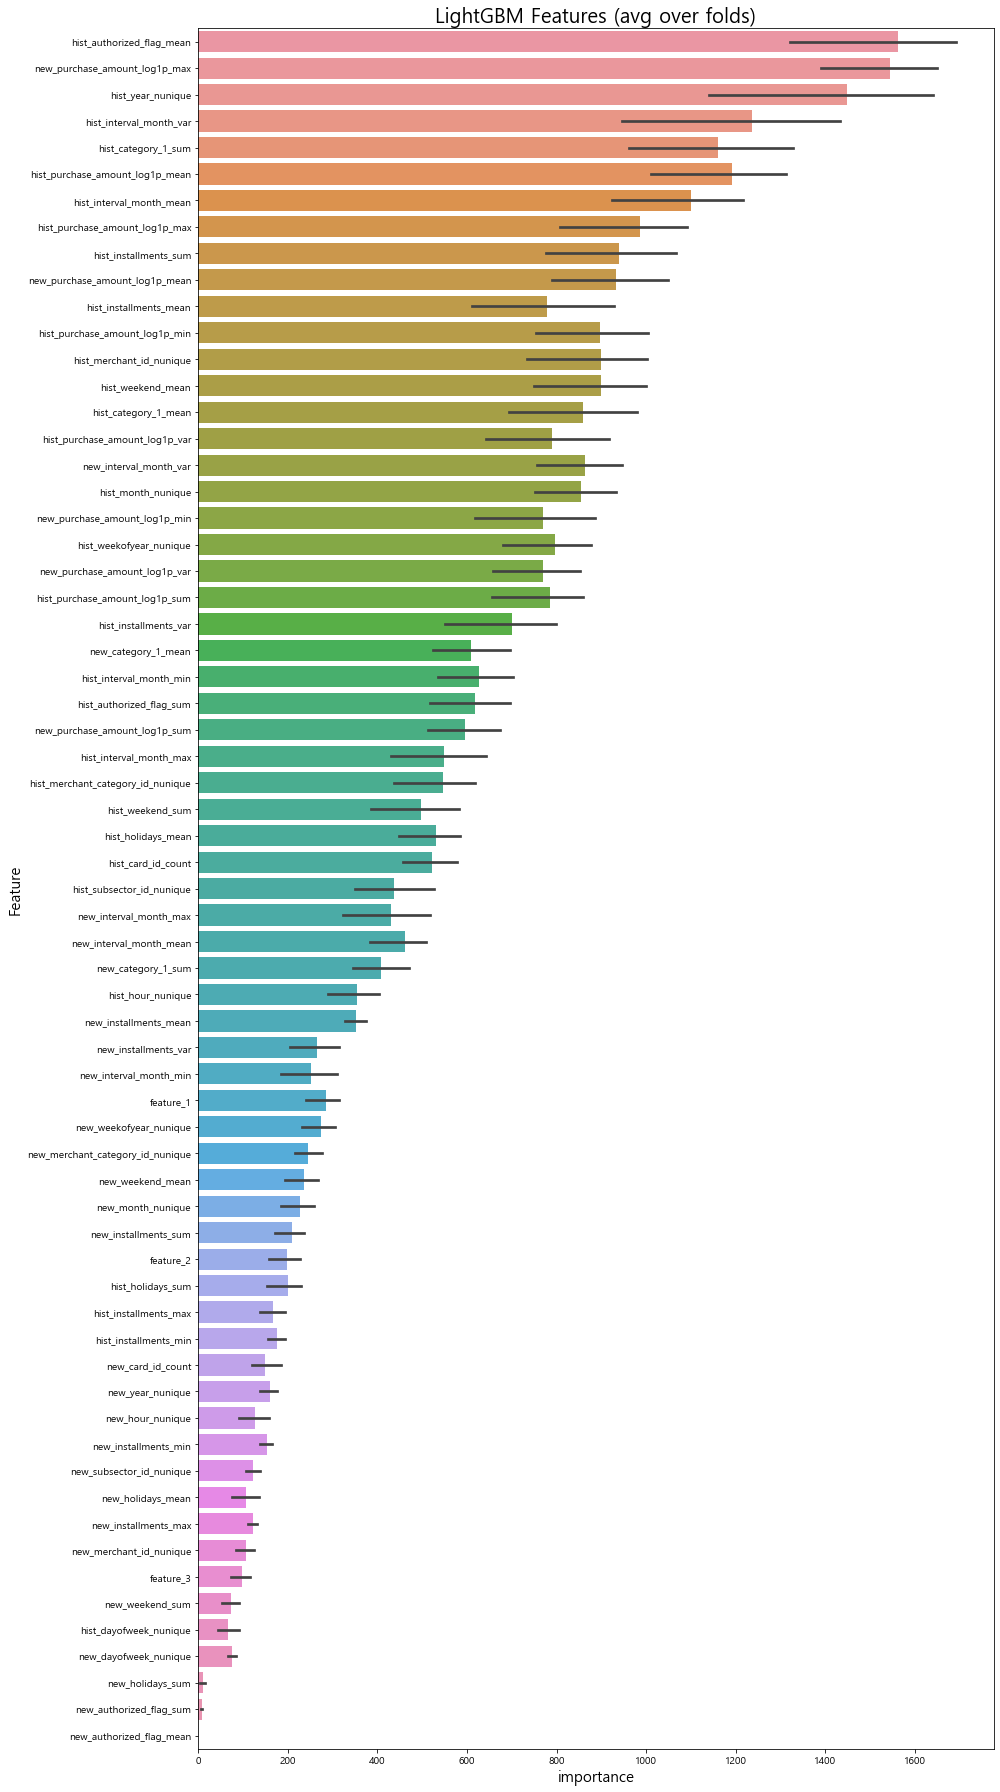

In [18]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [19]:
df_train.corr().mean().sort_values(ascending=False)

hist_merchant_category_id_nunique    0.189894
hist_merchant_id_nunique             0.189316
hist_subsector_id_nunique            0.183378
hist_authorized_flag_sum             0.170452
hist_card_id_count                   0.169487
                                       ...   
feature_3                           -0.016766
hist_installments_min               -0.017524
new_purchase_amount_log1p_sum       -0.125600
hist_purchase_amount_log1p_sum      -0.146627
new_authorized_flag_mean                  NaN
Length: 66, dtype: float64

In [20]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("D:/kaggle/ELO/data/new/model/submission.csv", index=False)

In [23]:
df_train_columns

['hist_card_id_count',
 'hist_month_nunique',
 'hist_hour_nunique',
 'hist_weekofyear_nunique',
 'hist_dayofweek_nunique',
 'hist_year_nunique',
 'hist_subsector_id_nunique',
 'hist_merchant_id_nunique',
 'hist_merchant_category_id_nunique',
 'hist_installments_sum',
 'hist_installments_max',
 'hist_installments_min',
 'hist_installments_mean',
 'hist_installments_var',
 'hist_authorized_flag_sum',
 'hist_authorized_flag_mean',
 'hist_weekend_sum',
 'hist_weekend_mean',
 'hist_category_1_sum',
 'hist_category_1_mean',
 'hist_purchase_amount_log1p_sum',
 'hist_purchase_amount_log1p_max',
 'hist_purchase_amount_log1p_min',
 'hist_purchase_amount_log1p_mean',
 'hist_purchase_amount_log1p_var',
 'hist_interval_month_max',
 'hist_interval_month_min',
 'hist_interval_month_mean',
 'hist_interval_month_var',
 'hist_holidays_sum',
 'hist_holidays_mean',
 'new_card_id_count',
 'new_month_nunique',
 'new_hour_nunique',
 'new_weekofyear_nunique',
 'new_dayofweek_nunique',
 'new_year_nunique',
 'n